In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset from the Excel file
file_path = 'XOOM_Duke_2014_2024.csv'  # Update this with the actual file path
data = pd.read_csv(file_path)

In [3]:
# Ensure 'PublishDate' is a datetime type for proper plotting
data['PublishDate'] = pd.to_datetime(data['PublishDate'])

## 1. Time series data check

In [4]:
# Function to plot time series for each numerical column
def plot_time_series(data, time_column):
    # Iterate over all columns in the dataframe
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]):  # Check if the column is numeric
            plt.figure(figsize=(12, 6))
            plt.plot(data[time_column], data[column], label=column, marker='o')
            plt.title(f'Time Series Plot of {column}')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()

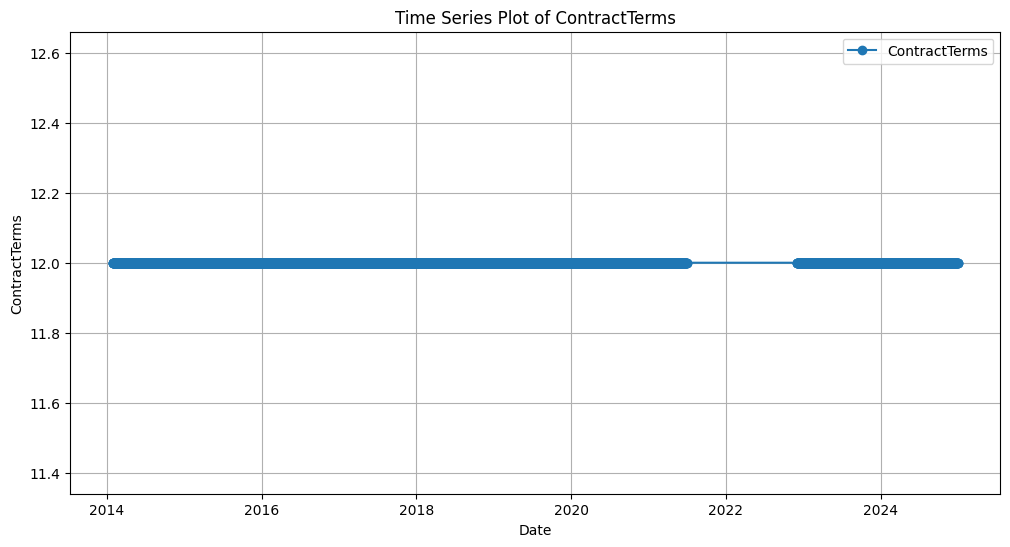

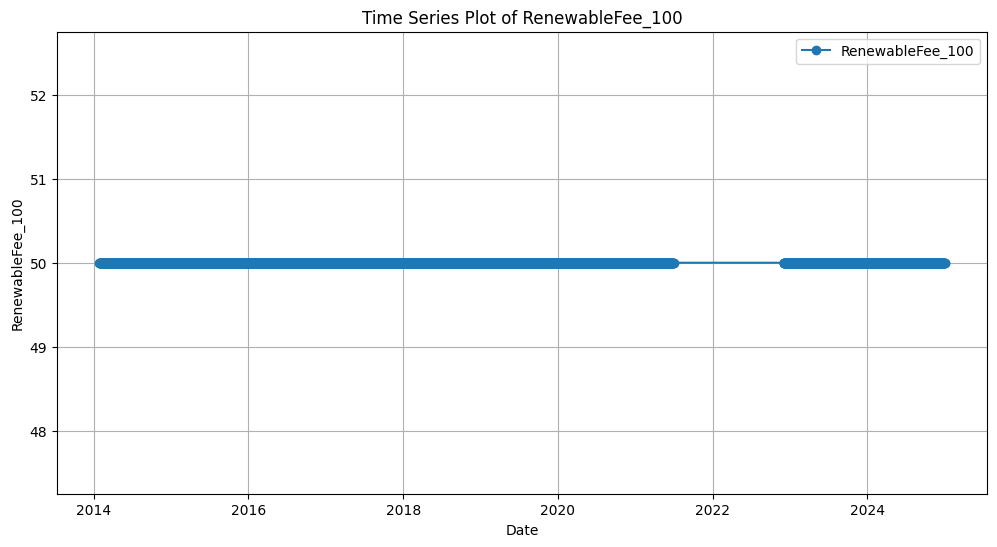

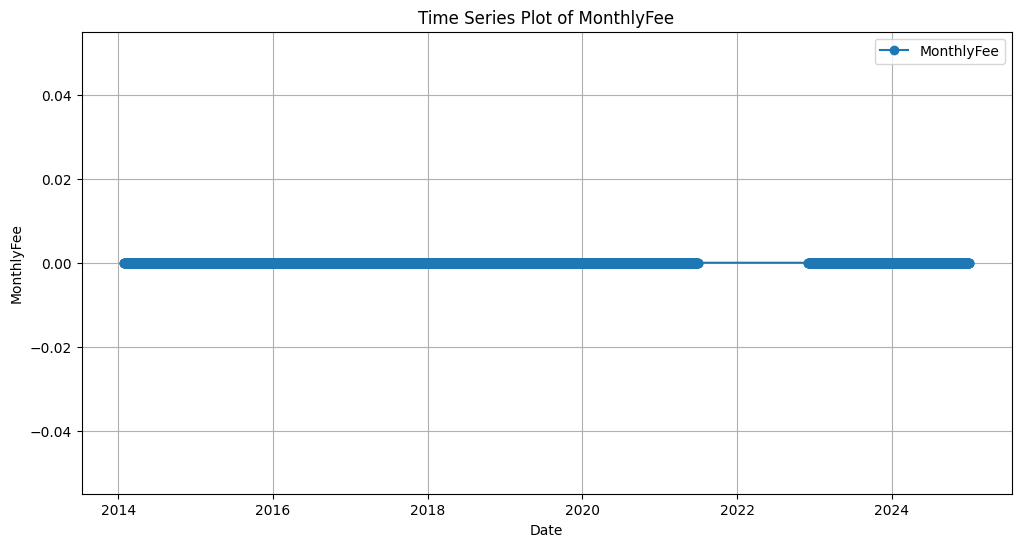

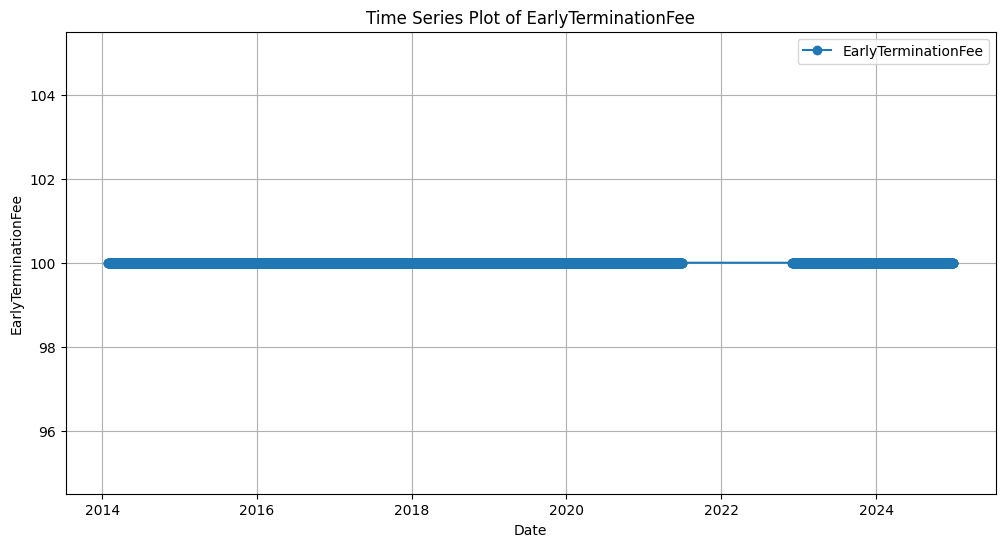

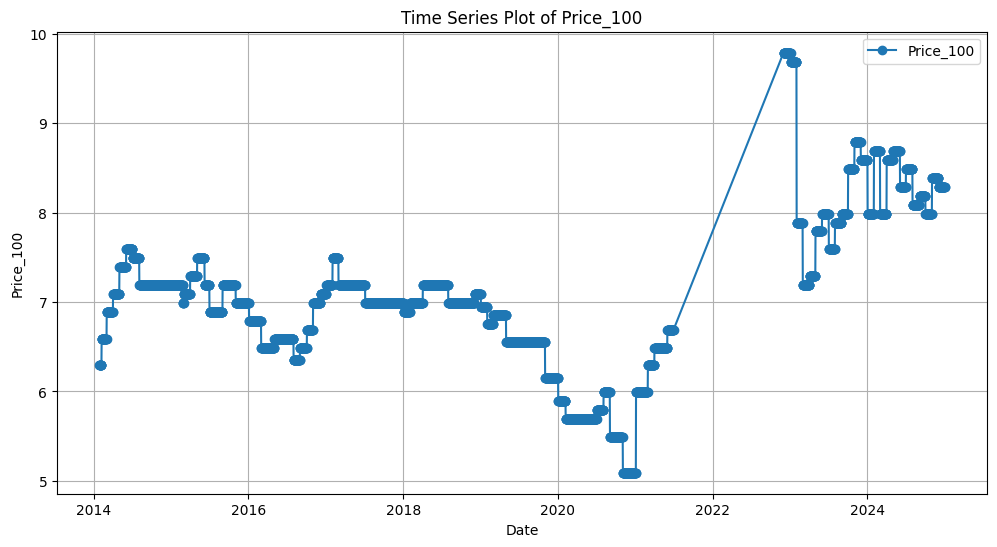

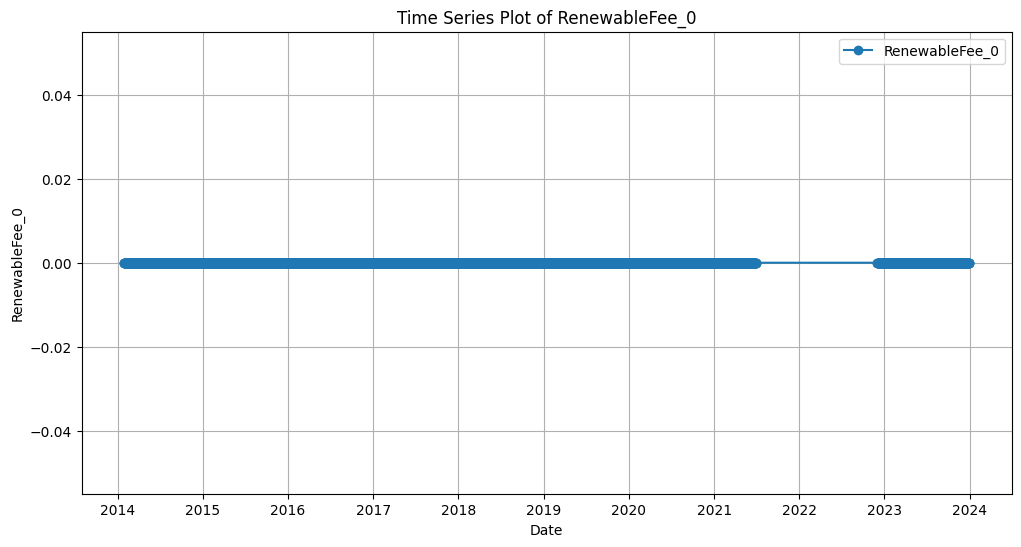

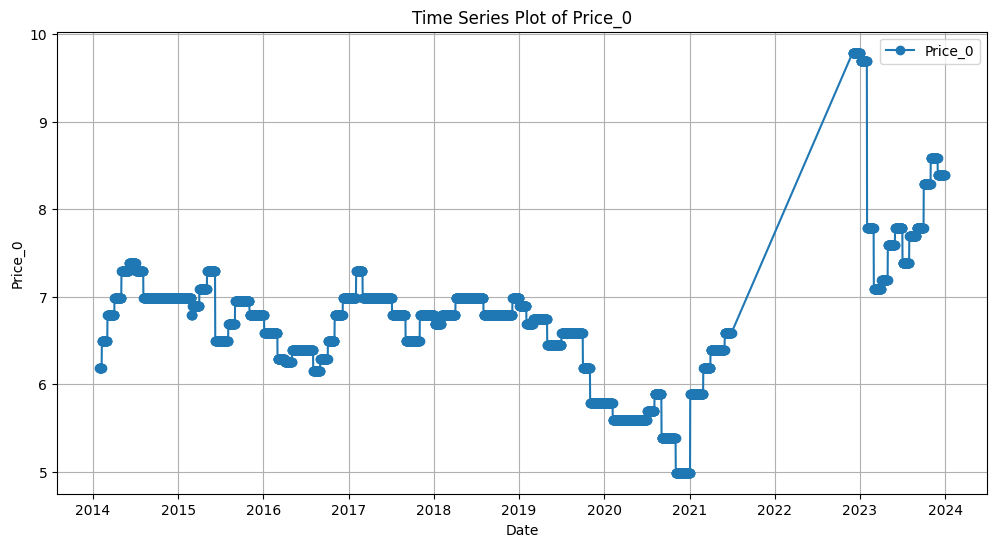

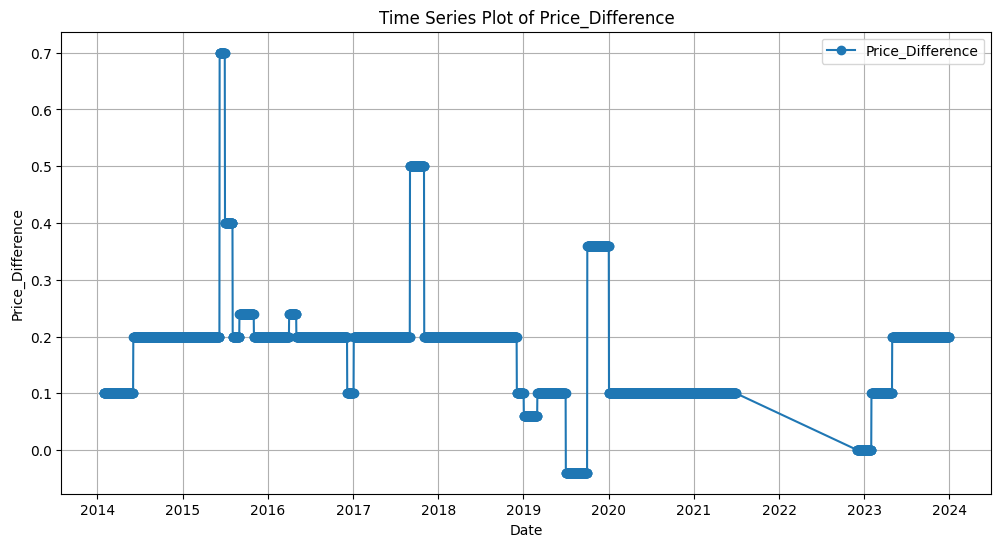

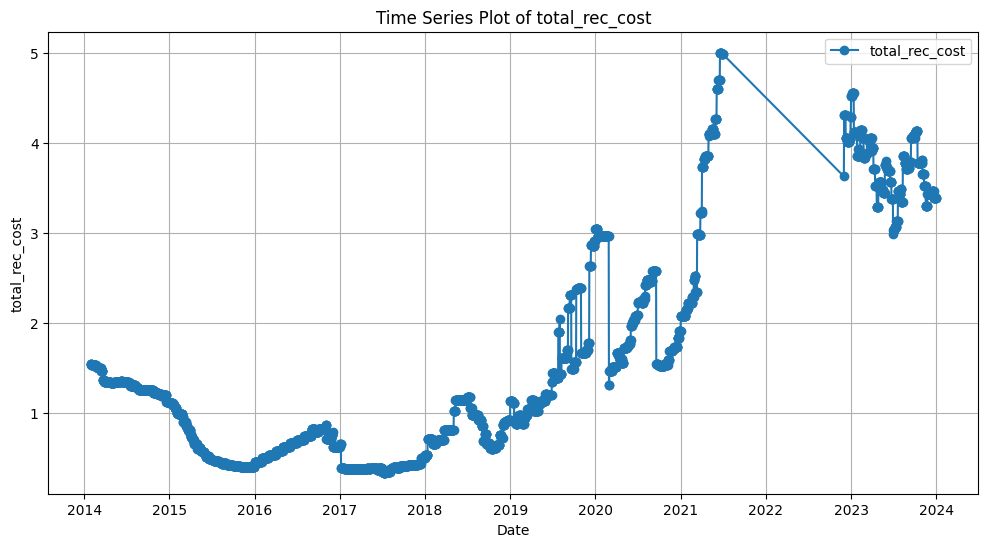

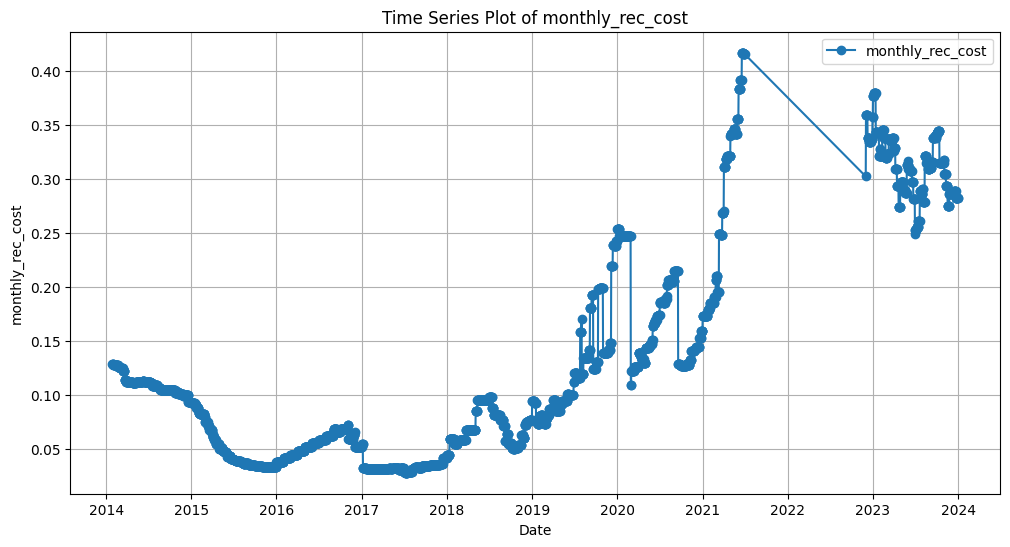

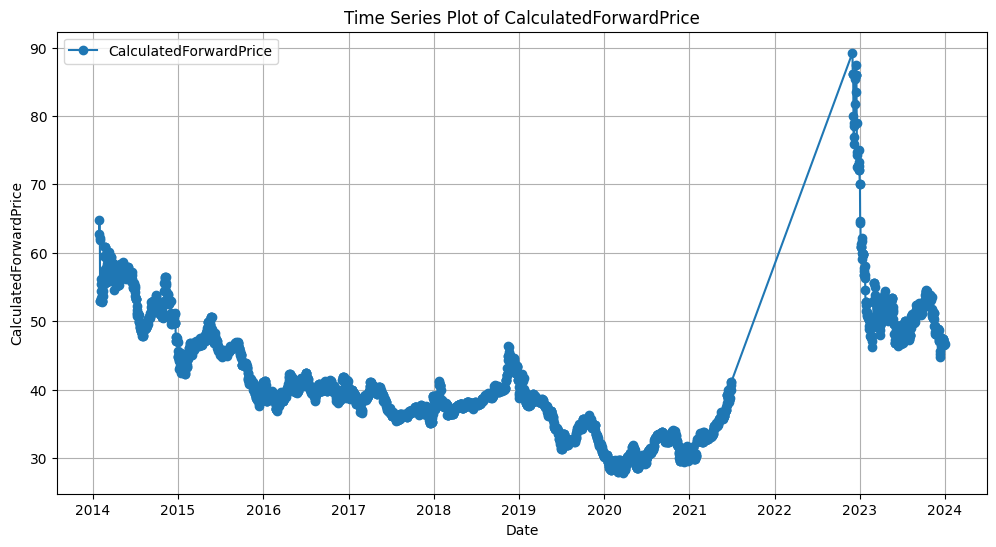

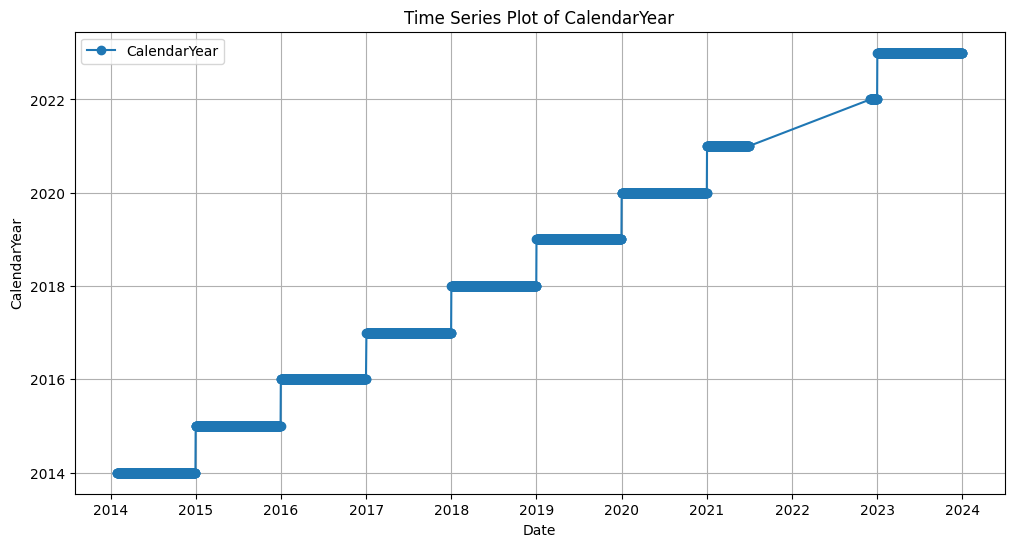

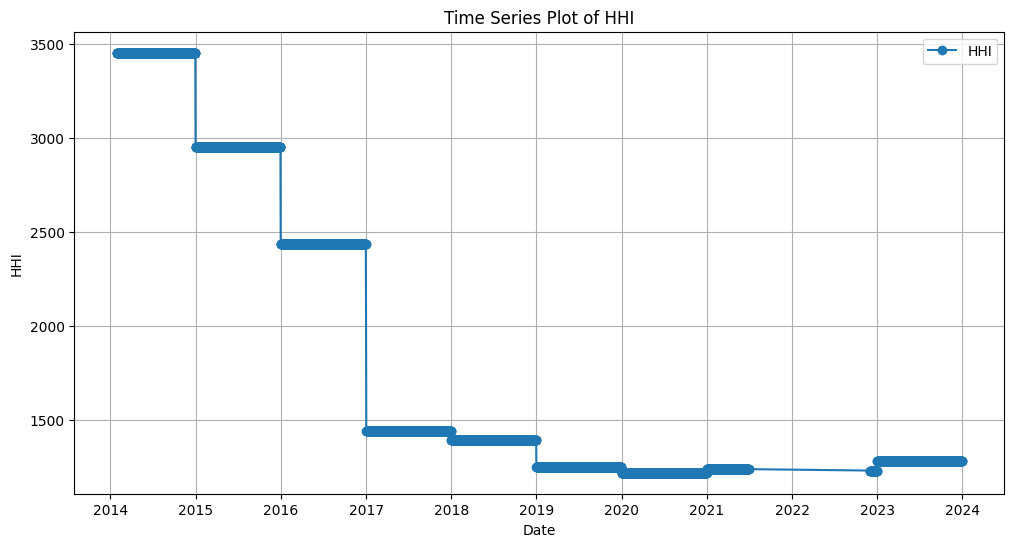

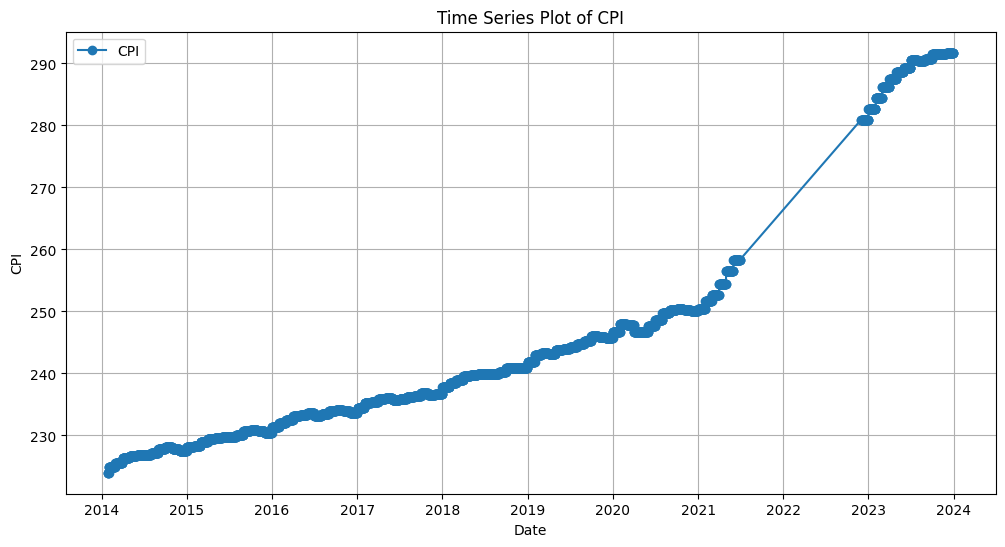

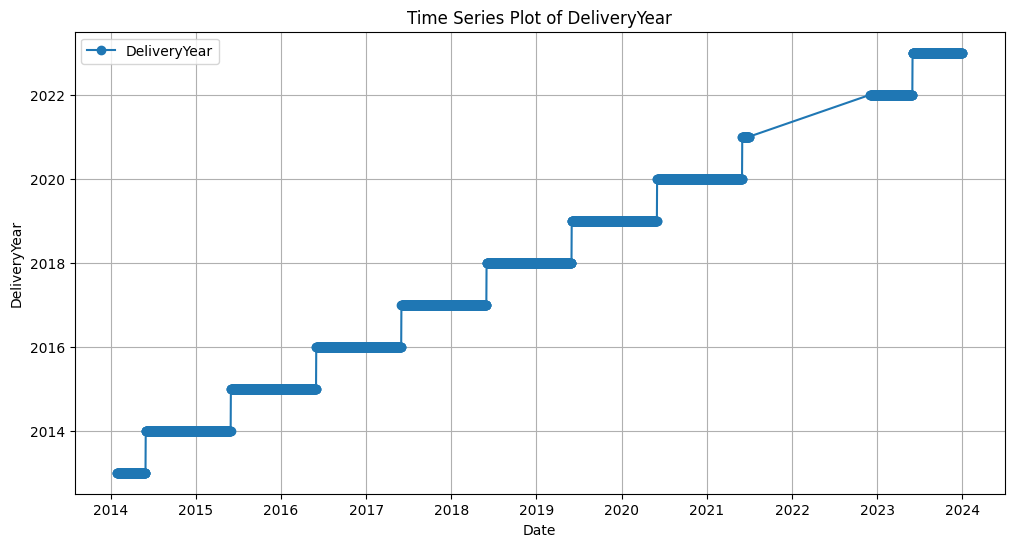

In [5]:
# Call the function with the dataset and the specific time column
plot_time_series(data, 'PublishDate')

## 2. LSTM model
### Data segemention for series with missing time steps

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
input_file="XOOM_Duke_2014_2024.csv"
df = pd.read_csv(input_file, header=None, index_col=None, delimiter=',')

# Assuming the first row is the header and the first column contains the dates
df.columns = df.iloc[0]  # Set the first row as column names
df = df[1:]  # Remove the first row
df['Date'] = pd.to_datetime(df.iloc[:, 0])  # Convert the first column to datetime

# Prepare the 8th column for training (assuming it's the target variable)
price = df.iloc[:, 7].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(price.values.reshape(-1, 1))

In [3]:
# Parameters
look_back = 7

In [4]:
# Function to create segments from time series data
def create_segments(data, look_back):
    segments = []
    labels = []
    for i in range(len(data) - 2*look_back-1):
        print(i)
        segment = data[i:(i + look_back)]    
        label = data[(i + look_back + 1):(i + 2*look_back+1)]
        print (segment)
        print (label)
        segments.append(segment)
        labels.append(label)
    return np.array(segments), np.array(labels)

In [5]:
# Divide the data into two parts based on the discontinuity
data_part1 = data[:2699]
data_part2 = data[2699:]

# Create segments for each part
segments1, labels1 = create_segments(data_part1, look_back)
segments2, labels2 = create_segments(data_part2, look_back)

0
[[0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]]
[[0.25531915]
 [0.25531915]
 [0.25531915]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]]
1
[[0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]]
[[0.25531915]
 [0.25531915]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]]
2
[[0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]]
[[0.25531915]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]]
3
[[0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]]
[[0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]]
4
[[0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]
 [0.25531915]]
[[0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]
 [0.31914894]]


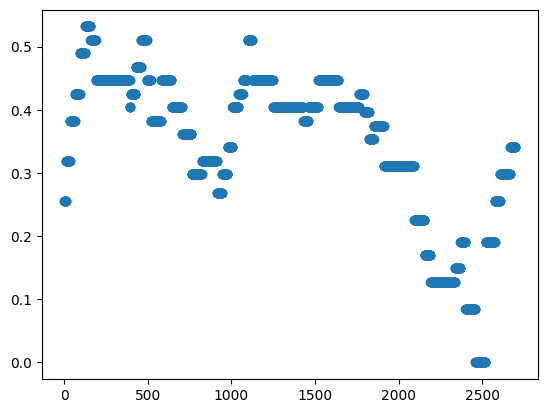

In [6]:
plt.scatter(range(len(data_part1)), data_part1)


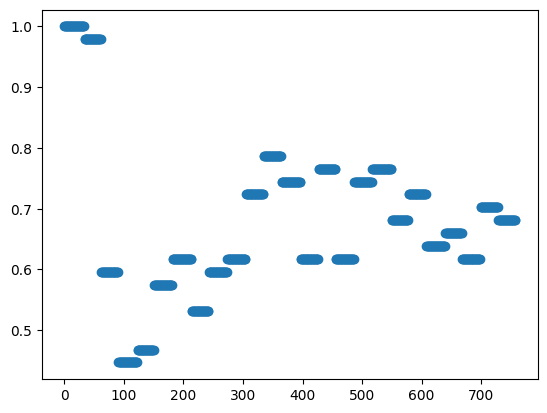

In [7]:
plt.scatter(range(len(data_part2)), data_part2)


In [8]:
segments_combined = np.concatenate((segments1, segments2), axis=0)
labels_combined = np.concatenate((labels1, labels2), axis=0)


In [9]:
print(np.size(segments_combined))
print(np.size(labels_combined))

23989
23989


In [10]:
# Set a seed for reproducibility
np.random.seed(15)

# Shuffle combined segments
indices = np.arange(segments_combined.shape[0])
np.random.shuffle(indices)
segments_shuffled = segments_combined[indices]
labels_shuffled = labels_combined[indices]

train_val_segments, test_segments, train_val_labels, test_labels = train_test_split(
    segments_shuffled, labels_shuffled, test_size=0.2, random_state=42
)

train_segments, val_segments, train_labels, val_labels = train_test_split(
    train_val_segments, train_val_labels, test_size=0.25, random_state=42
)


In [11]:
print(train_segments.shape)
print(train_labels.shape)

print(val_segments.shape)
print(val_labels.shape)

print(test_segments.shape)
print(test_labels.shape)


(2055, 7, 1)
(2055, 7, 1)
(686, 7, 1)
(686, 7, 1)
(686, 7, 1)
(686, 7, 1)


In [12]:
# Assigning data directly without reshaping since it's already in the correct format
trainX = train_segments
trainY = train_labels

valX = val_segments
valY = val_labels

testX = test_segments
testY = test_labels


In [13]:
np.size(trainX)

14385

In [14]:
trainX.shape[1]

7

In [15]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train model with a validation split
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(valX, valY), verbose=2)

Epoch 1/500


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 - 2s - 57ms/step - loss: 0.1209 - val_loss: 0.0490
Epoch 2/500
33/33 - 0s - 5ms/step - loss: 0.0388 - val_loss: 0.0334
Epoch 3/500
33/33 - 0s - 4ms/step - loss: 0.0300 - val_loss: 0.0267
Epoch 4/500
33/33 - 0s - 5ms/step - loss: 0.0241 - val_loss: 0.0211
Epoch 5/500
33/33 - 0s - 4ms/step - loss: 0.0189 - val_loss: 0.0164
Epoch 6/500
33/33 - 0s - 5ms/step - loss: 0.0151 - val_loss: 0.0131
Epoch 7/500
33/33 - 0s - 4ms/step - loss: 0.0125 - val_loss: 0.0109
Epoch 8/500
33/33 - 0s - 4ms/step - loss: 0.0107 - val_loss: 0.0093
Epoch 9/500
33/33 - 0s - 5ms/step - loss: 0.0093 - val_loss: 0.0081
Epoch 10/500
33/33 - 0s - 4ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 11/500
33/33 - 0s - 5ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 12/500
33/33 - 0s - 5ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 13/500
33/33 - 0s - 4ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 14/500
33/33 - 0s - 4ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 15/500
33/33 - 0s - 5ms/step - loss: 0.0050 - va

In [16]:
# make predictions
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [17]:
train_predictions_flattened = trainPredict.reshape(-1, 1)  # Reshape to (samples * sequence_length, 1)
train_labels_flattened = trainY.reshape(-1, 1)  # Same reshaping

# Invert scaling
train_predictions_inverted = scaler.inverse_transform(train_predictions_flattened)
train_labels_inverted = scaler.inverse_transform(train_labels_flattened)

# Calculate MAE
mae = mean_absolute_error(train_labels_inverted, train_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(train_labels_inverted, train_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((train_labels_inverted - train_predictions_inverted) / train_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(train_labels_inverted, train_predictions_inverted)
print(f"R-squared Error: {r2}")

Mean Absolute Error: 0.0617431469301735
Root Mean Squared Error: 0.14695200534637962
Mean Absolute Percentage Error: 0.008498809550184627
R-squared Error: 0.9686005169710943


In [18]:
val_predictions_flattened = valPredict.reshape(-1, 1)  # Reshape to (samples * sequence_length, 1)
val_labels_flattened = valY.reshape(-1, 1)  # Same reshaping

# Invert scaling
val_predictions_inverted = scaler.inverse_transform(val_predictions_flattened)
val_labels_inverted = scaler.inverse_transform(val_labels_flattened)

# Calculate MAE
mae = mean_absolute_error(val_labels_inverted, val_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(val_labels_inverted, val_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((val_labels_inverted - val_predictions_inverted) / val_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(val_labels_inverted, val_predictions_inverted)
print(f"R-squared Error: {r2}")

Mean Absolute Error: 0.0648908098515547
Root Mean Squared Error: 0.16553556490320928
Mean Absolute Percentage Error: 0.008895863833767085
R-squared Error: 0.9630514905660059


In [19]:
test_predictions_flattened = testPredict.reshape(-1, 1)  # Reshape to (samples * sequence_length, 1)
test_labels_flattened = testY.reshape(-1, 1)  # Same reshaping

# Invert scaling
test_predictions_inverted = scaler.inverse_transform(test_predictions_flattened)
test_labels_inverted = scaler.inverse_transform(test_labels_flattened)

# Calculate MAE
mae = mean_absolute_error(test_labels_inverted, test_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(test_labels_inverted, test_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((test_labels_inverted - test_predictions_inverted) / test_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(test_labels_inverted, test_predictions_inverted)
print(f"R-squared Error: {r2}")

Mean Absolute Error: 0.06346643563063631
Root Mean Squared Error: 0.1534938669644718
Mean Absolute Percentage Error: 0.008798788325017315
R-squared Error: 0.9677716743135684


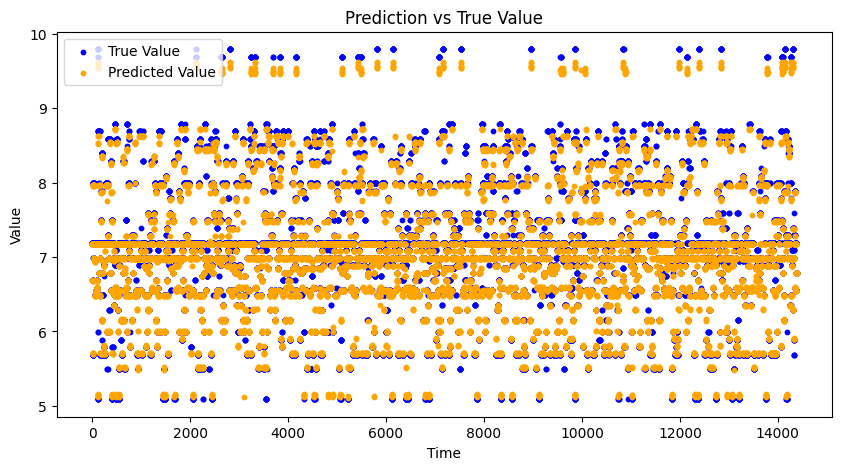

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(train_labels_inverted)), train_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(train_predictions_inverted)), train_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

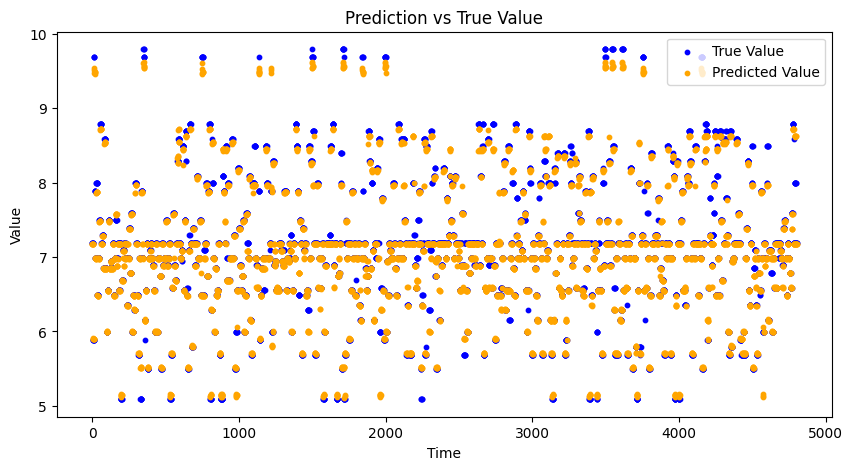

In [21]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(val_labels_inverted)), val_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(val_predictions_inverted)), val_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

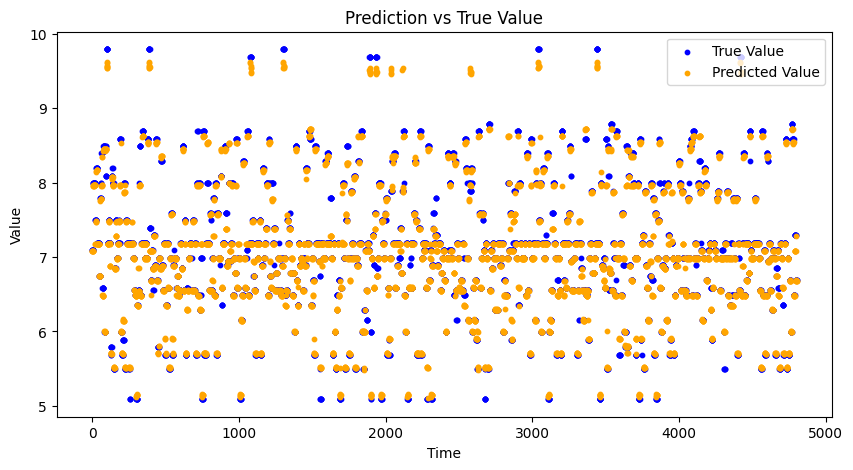

In [22]:
# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(range(len(test_labels_inverted)), test_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(test_predictions_inverted)), test_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


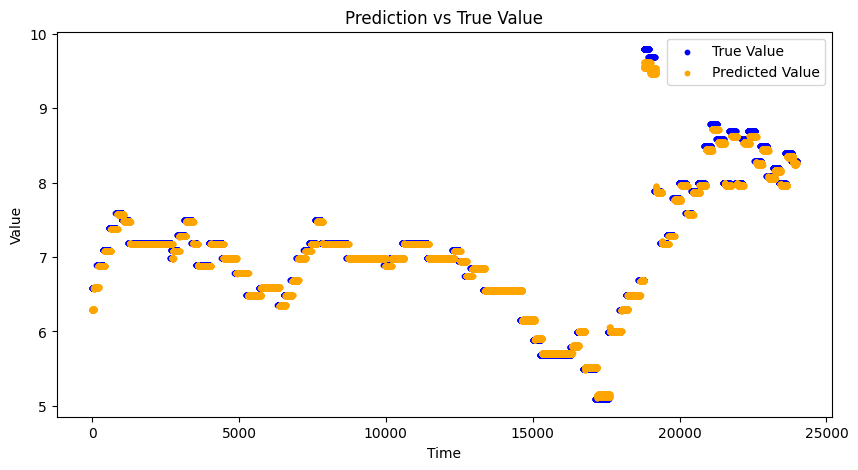

In [23]:
# Prepare data for prediction
data_segments = segments_combined
data_labels = labels_combined

dataX = data_segments.reshape((data_segments.shape[0], data_segments.shape[1], 1))
dataY = data_labels

predictions = model.predict(dataX)
predictions_flattened = predictions.reshape(-1, 1)
predictions_inverted = scaler.inverse_transform(predictions_flattened)

dataY_flattened = dataY.reshape(-1, 1)
dataY_inverted = scaler.inverse_transform(dataY_flattened)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(dataY_inverted)), dataY_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(predictions_inverted)), predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 3. Random forest model

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [2]:
input_file="XOOM_Duke_2014_2024.csv"
df = pd.read_csv(input_file, header=None, index_col=None, delimiter=',')

# Assuming the first row is the header and the first column contains the dates
df.columns = df.iloc[0]  # Set the first row as column names
df = df[1:]  # Remove the first row
df['Date'] = pd.to_datetime(df.iloc[:, 0])  # Convert the first column to datetime

# Prepare the 8th column for training (assuming it's the target variable)
price = df.iloc[:, 7].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(price.values.reshape(-1, 1))

# Parameters
look_back = 7

# Function to create segments from time series data
def create_segments(data, look_back):
    segments = []
    labels = []
    for i in range(len(data) - look_back-1):
        segment = data[i:(i + look_back)]    
        label = data[i + look_back + 1]
        segments.append(segment)
        labels.append(label)
    return np.array(segments), np.array(labels)

# Divide the data into two parts based on the discontinuity
data_part1 = data[:2699]
data_part2 = data[2699:]

# Create segments for each part
segments1, labels1 = create_segments(data_part1, look_back)
segments2, labels2 = create_segments(data_part2, look_back)

segments_combined = np.concatenate((segments1, segments2), axis=0)
labels_combined = np.concatenate((labels1, labels2), axis=0)

# Set a seed for reproducibility
np.random.seed(15)

# Shuffle combined segments
indices = np.arange(segments_combined.shape[0])
np.random.shuffle(indices)
segments_shuffled = segments_combined[indices]
labels_shuffled = labels_combined[indices]

# Split into train + validation and test sets
train_val_segments, test_segments, train_val_labels, test_labels = train_test_split(
    segments_shuffled, labels_shuffled, test_size=0.2
)

# Split into train and validation 
train_segments, val_segments, train_labels, val_labels = train_test_split(
    train_val_segments, train_val_labels, test_size=0.25
)

trainX = train_segments.reshape((train_segments.shape[0], train_segments.shape[1], 1))
trainY = train_labels

valX = val_segments.reshape((val_segments.shape[0], val_segments.shape[1], 1))
valY = val_labels

testX = test_segments.reshape((test_segments.shape[0], test_segments.shape[1], 1))
testY = test_labels

In [3]:
# Flatten the data for Random Forest
trainX_rf = train_segments.reshape(train_segments.shape[0], -1)
valX_rf = val_segments.reshape(val_segments.shape[0], -1)
testX_rf = test_segments.reshape(test_segments.shape[0], -1)

In [9]:
n_estimators_options = [50, 100, 200]
max_depth_options = [5, 10, 15]  # None means no limit

best_mse = float('inf')
best_model = None

In [10]:
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(trainX_rf, trainY)
        val_predictions = model.predict(valX_rf)
        mse = mean_squared_error(valY, val_predictions)

        print(f"Testing model with {n_estimators} trees and max depth {max_depth}: MSE = {mse}")

        if mse < best_mse:
            best_mse = mse
            best_model = model

print("Best model:", best_model)

c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing model with 50 trees and max depth 5: MSE = 0.00015644802461844043
Testing model with 50 trees and max depth 10: MSE = 0.00014288999055177105
Testing model with 50 trees and max depth 15: MSE = 0.00014294486126970296


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing model with 100 trees and max depth 5: MSE = 0.00015814672689468262
Testing model with 100 trees and max depth 10: MSE = 0.0001431692913303789


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing model with 100 trees and max depth 15: MSE = 0.00014318851082549484


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing model with 200 trees and max depth 5: MSE = 0.00015941377764024542


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing model with 200 trees and max depth 10: MSE = 0.00014330194921652608


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing model with 200 trees and max depth 15: MSE = 0.0001433172237630038
Best model: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)


In [11]:
train_predictions = best_model.predict(trainX_rf)
val_predictions = best_model.predict(valX_rf)
test_predictions = best_model.predict(testX_rf)

Mean Absolute Error: 0.020144597891730266
Root Mean Squared Error: 0.07380823123250431
Mean Absolute Percentage Error: 0.0028191571082242257
R-squared Error: 0.9923970254973148


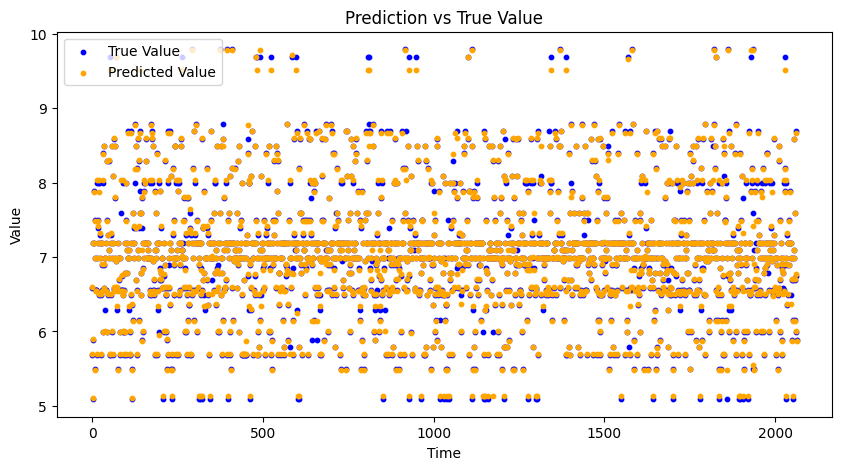

In [12]:
train_predictions_inverted = scaler.inverse_transform(train_predictions.reshape(-1, 1))
train_labels_inverted = scaler.inverse_transform(trainY.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(train_labels_inverted, train_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(train_labels_inverted, train_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((train_labels_inverted - train_predictions_inverted) / train_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(train_labels_inverted, train_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(train_labels_inverted)), train_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(train_predictions_inverted)), train_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean Absolute Error: 0.02019031898259295
Root Mean Squared Error: 0.05618220262047961
Mean Absolute Percentage Error: 0.0029114384775172997
R-squared Error: 0.9955696101633525


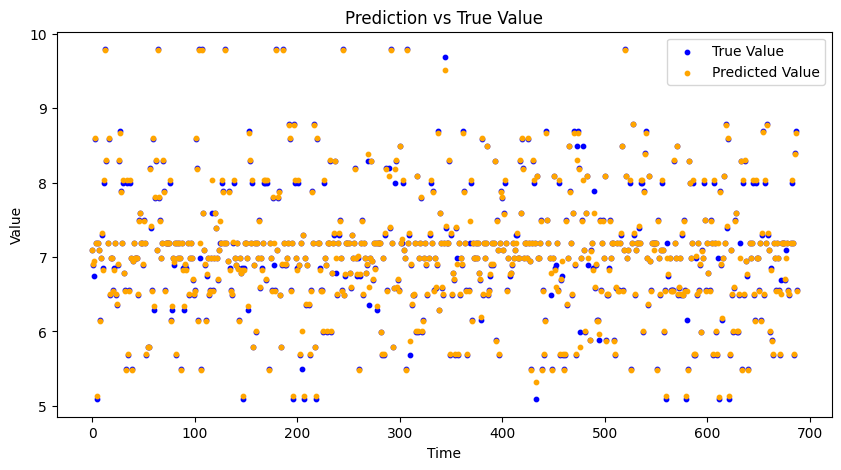

In [13]:
val_predictions_inverted = scaler.inverse_transform(val_predictions.reshape(-1, 1))
val_labels_inverted = scaler.inverse_transform(valY.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(val_labels_inverted, val_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(val_labels_inverted, val_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((val_labels_inverted - val_predictions_inverted) / val_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(val_labels_inverted, val_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(val_labels_inverted)), val_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(val_predictions_inverted)), val_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Mean Absolute Error: 0.025733826513089118
Root Mean Squared Error: 0.0977883636311649
Mean Absolute Percentage Error: 0.00352837371793535
R-squared Error: 0.986412815334849


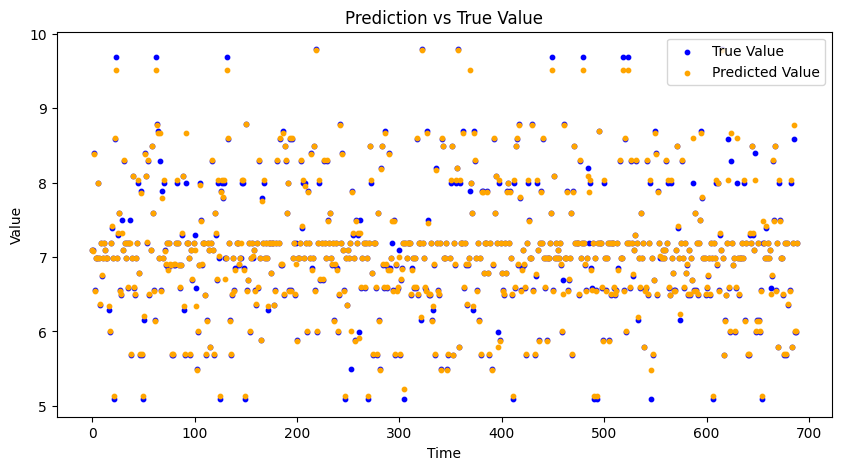

In [14]:
test_predictions_inverted = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_labels_inverted = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(test_labels_inverted, test_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(test_labels_inverted, test_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((test_labels_inverted - test_predictions_inverted) / test_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(test_labels_inverted, test_predictions_inverted)
print(f"R-squared Error: {r2}")

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(range(len(test_labels_inverted)), test_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(test_predictions_inverted)), test_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



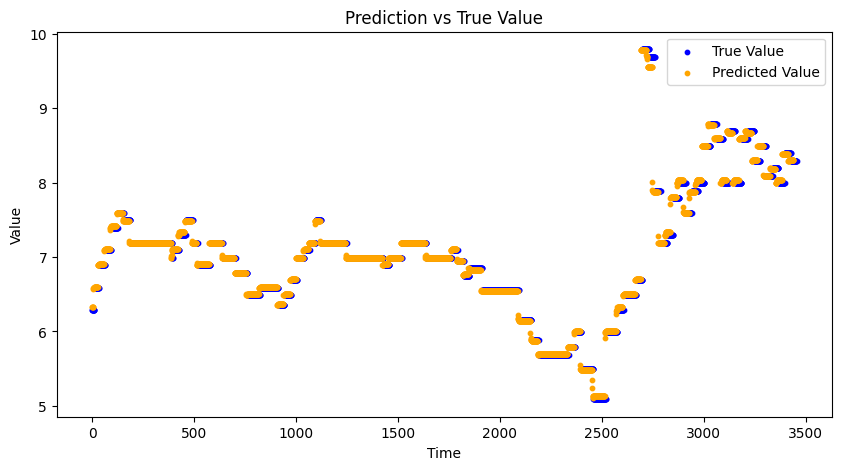

In [15]:
# Prepare data for prediction
data_segments = segments_combined
data_labels = labels_combined

dataX = data_segments.reshape((data_segments.shape[0], -1))
dataY = data_labels

predictions = model.predict(dataX)
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.scatter(range(len(price)), price, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(predictions_inverted)), predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 4. XGBoost

In [7]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
input_file="XOOM_Duke_2014_2024.csv"
df = pd.read_csv(input_file, header=None, index_col=None, delimiter=',')

# Assuming the first row is the header and the first column contains the dates
df.columns = df.iloc[0]  # Set the first row as column names
df = df[1:]  # Remove the first row
df['Date'] = pd.to_datetime(df.iloc[:, 0])  # Convert the first column to datetime

# Prepare the 8th column for training (assuming it's the target variable)
price = df.iloc[:, 7].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(price.values.reshape(-1, 1))

# Parameters
look_back = 7

# Function to create segments from time series data
def create_segments(data, look_back):
    segments = []
    labels = []
    for i in range(len(data) - look_back-1):
        segment = data[i:(i + look_back)]    
        label = data[i + look_back + 1]
        segments.append(segment)
        labels.append(label)
    return np.array(segments), np.array(labels)

# Divide the data into two parts based on the discontinuity
data_part1 = data[:2699]
data_part2 = data[2699:]

# Create segments for each part
segments1, labels1 = create_segments(data_part1, look_back)
segments2, labels2 = create_segments(data_part2, look_back)

segments_combined = np.concatenate((segments1, segments2), axis=0)
labels_combined = np.concatenate((labels1, labels2), axis=0)

# Set a seed for reproducibility
np.random.seed(15)

# Shuffle combined segments
indices = np.arange(segments_combined.shape[0])
np.random.shuffle(indices)
segments_shuffled = segments_combined[indices]
labels_shuffled = labels_combined[indices]

# Split into train + validation and test sets
train_val_segments, test_segments, train_val_labels, test_labels = train_test_split(
    segments_shuffled, labels_shuffled, test_size=0.2
)

# Split into train and validation 
train_segments, val_segments, train_labels, val_labels = train_test_split(
    train_val_segments, train_val_labels, test_size=0.25
)

trainX = train_segments.reshape((train_segments.shape[0], train_segments.shape[1], 1))
trainY = train_labels

valX = val_segments.reshape((val_segments.shape[0], val_segments.shape[1], 1))
valY = val_labels

testX = test_segments.reshape((test_segments.shape[0], test_segments.shape[1], 1))
testY = test_labels

In [4]:
# Flatten the data for XGBoost
trainX_xg = train_segments.reshape(train_segments.shape[0], -1)
valX_xg = val_segments.reshape(val_segments.shape[0], -1)
testX_xg = test_segments.reshape(test_segments.shape[0], -1)

In [14]:
n_estimators_options = [50, 100, 200]
max_depth_options = [5, 10, 15]  # None means no limit

best_mse = float('inf')
best_model_xg = None

In [15]:
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(trainX_xg, trainY)
        val_predictions = model.predict(valX_xg)
        mse = mean_squared_error(valY, val_predictions)

        print(f"Testing model with {n_estimators} trees and max depth {max_depth}: MSE = {mse}")

        if mse < best_mse:
            best_mse = mse
            best_model_xg = model

print("Best model:", best_model_xg)


Testing model with 50 trees and max depth 5: MSE = 0.00014751706685501252
Testing model with 50 trees and max depth 10: MSE = 0.00014763486285931837
Testing model with 50 trees and max depth 15: MSE = 0.00014763486285931837
Testing model with 100 trees and max depth 5: MSE = 0.00014751716465895542
Testing model with 100 trees and max depth 10: MSE = 0.0001476349481998422
Testing model with 100 trees and max depth 15: MSE = 0.0001476349481998422
Testing model with 200 trees and max depth 5: MSE = 0.00014751722405778958
Testing model with 200 trees and max depth 10: MSE = 0.00014763500244876072
Testing model with 200 trees and max depth 15: MSE = 0.00014763500244876072
Best model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=N

In [16]:
train_predictions = best_model_xg.predict(trainX_xg)
val_predictions = best_model_xg.predict(valX_xg)
test_predictions = best_model_xg.predict(testX_xg)

Mean Absolute Error: 0.01969502241112473
Root Mean Squared Error: 0.07366928986355357
Mean Absolute Percentage Error: 0.0027603579629577623
R-squared Error: 0.9924256232127887


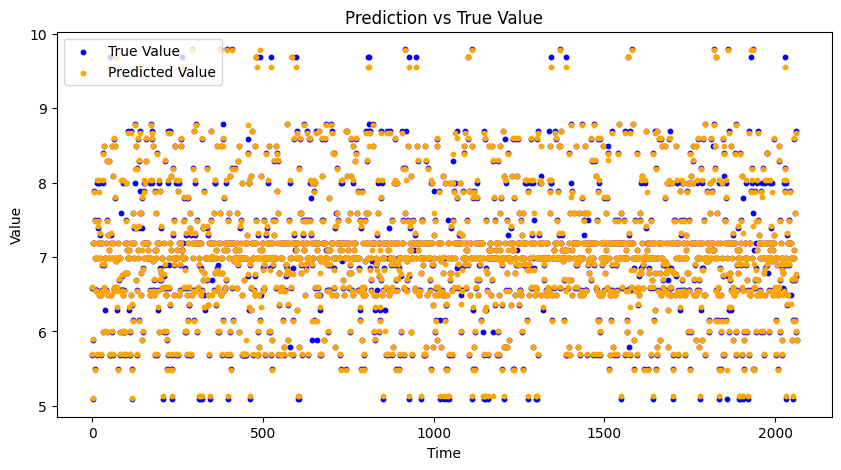

In [17]:
train_predictions_inverted = scaler.inverse_transform(train_predictions.reshape(-1, 1))
train_labels_inverted = scaler.inverse_transform(trainY.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(train_labels_inverted, train_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(train_labels_inverted, train_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((train_labels_inverted - train_predictions_inverted) / train_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(train_labels_inverted, train_predictions_inverted)
print(f"R-squared Error: {r2}")


plt.figure(figsize=(10, 5))
plt.scatter(range(len(train_labels_inverted)), train_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(train_predictions_inverted)), train_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean Absolute Error: 0.020078966756199756
Root Mean Squared Error: 0.057084579756273304
Mean Absolute Percentage Error: 0.0029010529522557685
R-squared Error: 0.9954261487632629


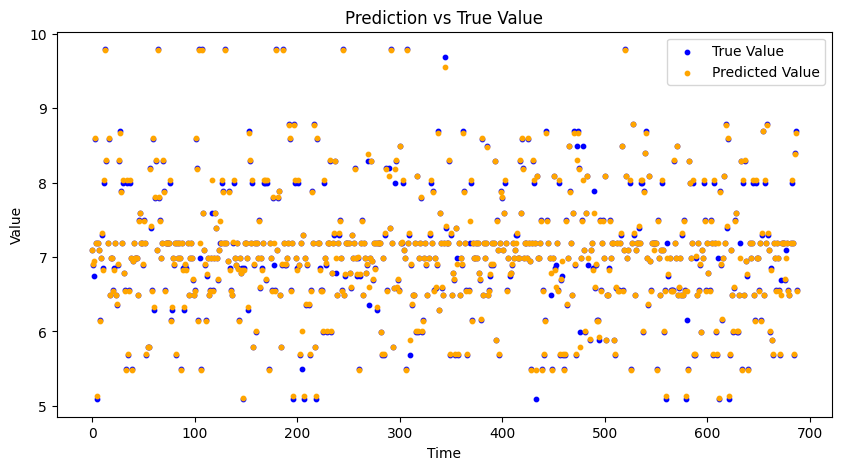

In [11]:
val_predictions_inverted = scaler.inverse_transform(val_predictions.reshape(-1, 1))
val_labels_inverted = scaler.inverse_transform(valY.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(val_labels_inverted, val_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(val_labels_inverted, val_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((val_labels_inverted - val_predictions_inverted) / val_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(val_labels_inverted, val_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(val_labels_inverted)), val_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(val_predictions_inverted)), val_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean Absolute Error: 0.02511904468730168
Root Mean Squared Error: 0.09877807628351308
Mean Absolute Percentage Error: 0.0034641181445434575
R-squared Error: 0.9861363926921136


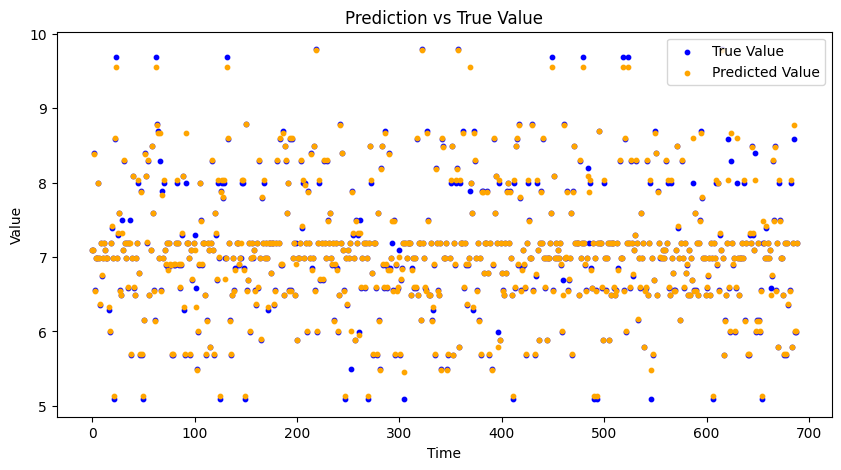

In [12]:
test_predictions_inverted = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_labels_inverted = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(test_labels_inverted, test_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(test_labels_inverted, test_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((test_labels_inverted - test_predictions_inverted) / test_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(test_labels_inverted, test_predictions_inverted)
print(f"R-squared Error: {r2}")

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(range(len(test_labels_inverted)), test_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(test_predictions_inverted)), test_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


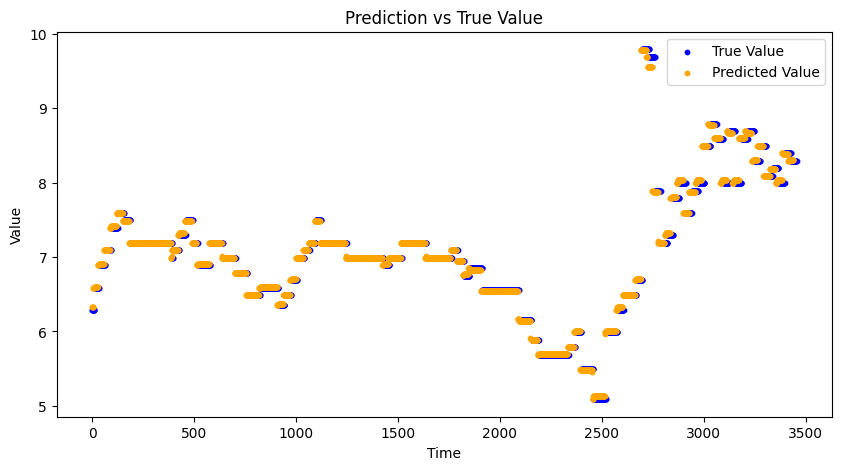

In [13]:
# Prepare data for prediction
data_segments = segments_combined
data_labels = labels_combined

dataX = data_segments.reshape((data_segments.shape[0], -1))
dataY = data_labels

predictions = model.predict(dataX)
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.scatter(range(len(price)), price, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(predictions_inverted)), predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



## 5. Autoregressive model

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [2]:
input_file="XOOM_Duke_2014_2024.csv"
df = pd.read_csv(input_file, header=None, index_col=None, delimiter=',')

# Assuming the first row is the header and the first column contains the dates
df.columns = df.iloc[0]  # Set the first row as column names
df = df[1:]  # Remove the first row
df['Date'] = pd.to_datetime(df.iloc[:, 0])  # Convert the first column to datetime

# Prepare the 8th column for training (assuming it's the target variable)
price = df.iloc[:, 7].astype(float)
scaler = MinMaxScaler()
data = scaler.fit_transform(price.values.reshape(-1, 1)).flatten()  # Flatten to make it a 1D array

# Divide the data into two parts based on the discontinuity
data_part1 = data[:2699]
data_part2 = data[2699:]

In [3]:
train_size_1 = int(len(data_part1) * 0.6)
val_size_1 = int(len(data_part1) * 0.2)

train_data_1, val_data_1, test_data_1 = data_part1[:train_size_1], data_part1[train_size_1 + 1:train_size_1 + val_size_1], data_part1[train_size_1 + val_size_1 + 1 :]

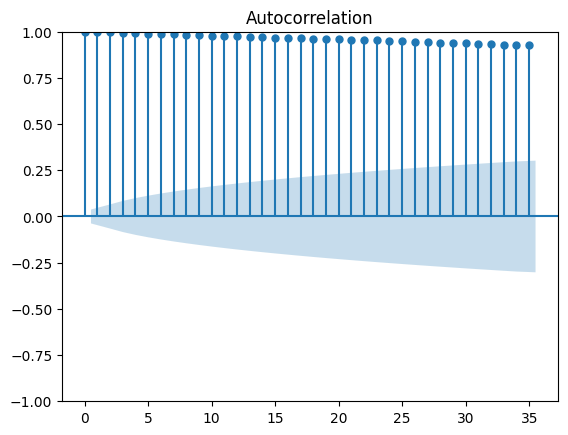

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
series = data_part1
plot_acf(series)
plt.show()

In [5]:
# Function to create AR model and evaluate it
def evaluate_ar_model(train_data, lags, val_data):
    model = sm.tsa.AutoReg(train_data, lags=lags, old_names=False)
    results = model.fit()
    start = len(train_data) + 1
    end = len(train_data) + len(val_data) 
    predictions = results.predict(start=start, end=end, dynamic=False)
    mse = mean_squared_error(val_data, predictions)
    return mse

# Initialize variables to track the best lag and its corresponding MSE
best_lag_1 = None
min_mse = float('inf')

# Checking different lag values
for lag in range(1, 7): 
    mse = evaluate_ar_model(train_data_1, lag, val_data_1)
    print(f'Lag: {lag}, Validation MSE: {mse}')
    
    # Update the best lag if the current MSE is lower than the min MSE observed so far
    if mse < min_mse:
        min_mse = mse
        best_lag_1 = lag

# Output the best lag value and its MSE
print(f'The best lag is {best_lag_1} with the lowest MSE of {min_mse}')

Lag: 1, Validation MSE: 0.010427564199398016
Lag: 2, Validation MSE: 0.01042089564045745
Lag: 3, Validation MSE: 0.01041423388805858
Lag: 4, Validation MSE: 0.010407579397189578
Lag: 5, Validation MSE: 0.010454656633306532
Lag: 6, Validation MSE: 0.01044804405920453
The best lag is 4 with the lowest MSE of 0.010407579397189578


In [6]:
tscv = TimeSeriesSplit(n_splits=7)
for train_index, test_index in tscv.split(data):
    train, test = data[train_index], data[test_index]
    model = sm.tsa.AutoReg(train, lags=best_lag_1)
    fitted_model = model.fit()
    predictions = fitted_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    mse = mean_squared_error(test, predictions)
    print(mse)

0.009000241539522603
0.0023930862584440487
0.0003883307871943566
0.011779345664847405
0.026430219604963247
0.12137518679017596
0.028513343350237665


In [7]:
train_predictions_1 = fitted_model.predict(start=best_lag_1, end=train_size_1)

val_predictions_1 = fitted_model.predict(start=train_size_1+1, end=train_size_1 + val_size_1-1)

test_predictions_1 = fitted_model.predict(start=train_size_1 + val_size_1 + 1, end=len(data_part1)-1)

Mean Absolute Error: 0.0010278231140639577
Root Mean Squared Error: 0.001319718039753248
Mean Absolute Percentage Error: 0.00014844095495233103
R-squared Error: 0.999977877760218


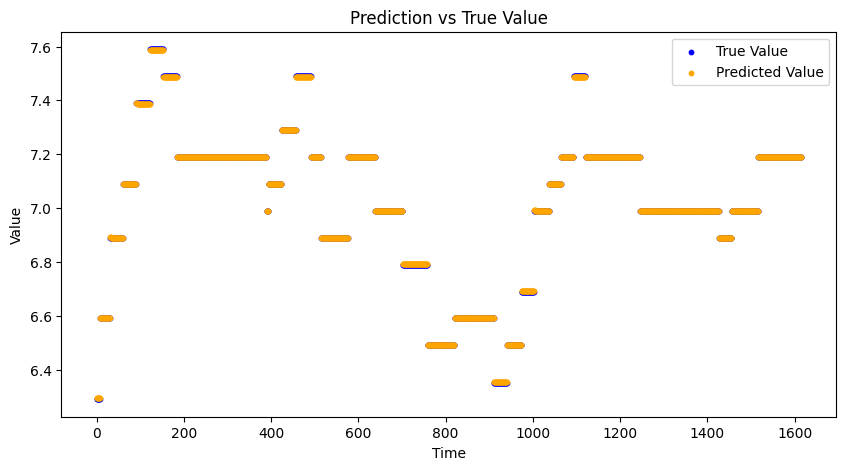

In [8]:
train_predictions_inverted = scaler.inverse_transform(train_predictions_1.reshape(-1, 1))
train_labels_inverted = scaler.inverse_transform(train_data_1[best_lag_1-1:].reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(train_labels_inverted, train_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(train_labels_inverted, train_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((train_labels_inverted - train_predictions_inverted) / train_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(train_labels_inverted, train_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(train_labels_inverted)), train_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(train_predictions_inverted)), train_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean Absolute Error: 0.0046696745884703406
Root Mean Squared Error: 0.028704940722392065
Mean Absolute Percentage Error: 0.0007205270095809053
R-squared Error: 0.9905588171988693


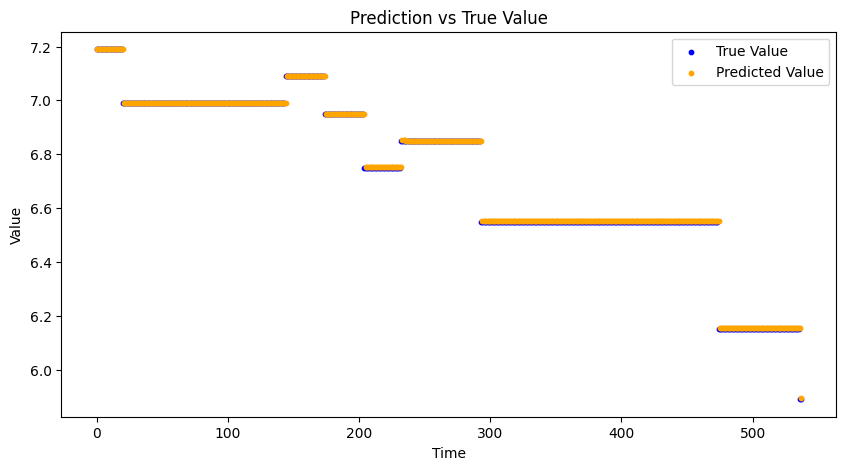

In [9]:
val_predictions_inverted = scaler.inverse_transform(val_predictions_1.reshape(-1, 1))
val_labels_inverted = scaler.inverse_transform(val_data_1.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(val_labels_inverted, val_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(val_labels_inverted, val_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((val_labels_inverted - val_predictions_inverted) / val_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(val_labels_inverted, val_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(val_labels_inverted)), val_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(val_predictions_inverted)), val_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean Absolute Error: 0.011045489666498366
Root Mean Squared Error: 0.05246877102751687
Mean Absolute Percentage Error: 0.0019225095771430915
R-squared Error: 0.9853124756990214


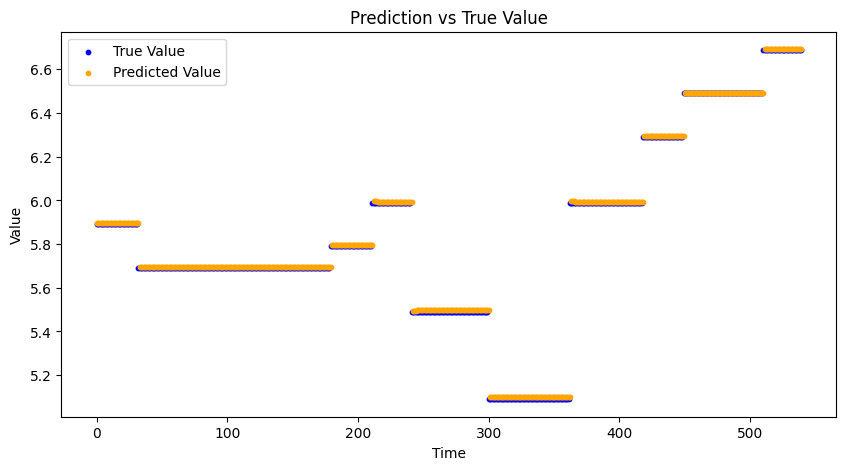

In [10]:
test_predictions_inverted = scaler.inverse_transform(test_predictions_1.reshape(-1, 1))
test_labels_inverted = scaler.inverse_transform(test_data_1.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(test_labels_inverted, test_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(test_labels_inverted, test_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((test_labels_inverted - test_predictions_inverted) / test_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(test_labels_inverted, test_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(test_labels_inverted)), test_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(test_predictions_inverted)), test_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [11]:
train_size_2 = int(len(data_part2) * 0.6)
val_size_2 = int(len(data_part2) * 0.2)

train_data_2, val_data_2, test_data_2 = data_part2[:train_size_2], data_part2[train_size_2 + 1:train_size_2 + val_size_2], data_part2[train_size_2 + val_size_2 + 1:]

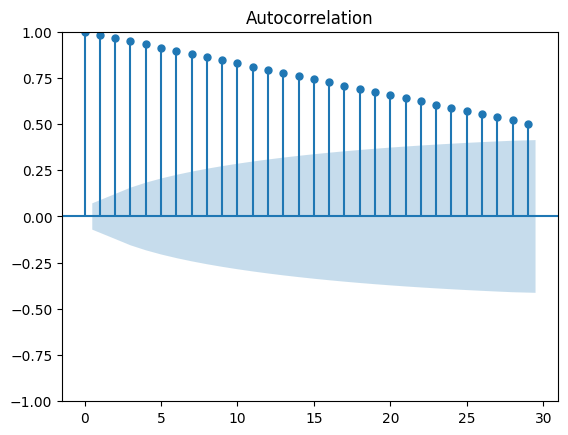

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
series = data_part2
plot_acf(series)
plt.show()

In [13]:
# Function to create AR model and evaluate it
def evaluate_ar_model(train_data, lags, val_data):
    model = sm.tsa.AutoReg(train_data, lags=lags, old_names=False)
    results = model.fit()
    start = len(train_data) + 1
    end = len(train_data) + len(val_data) 
    predictions = results.predict(start=start, end=end, dynamic=False)
    mse = mean_squared_error(val_data, predictions)
    return mse

# Initialize variables to track the best lag and its corresponding MSE
best_lag_2 = None
min_mse = float('inf')

# Checking different lag values
for lag in range(1, 7): 
    mse = evaluate_ar_model(train_data_2, lag, val_data_2)
    print(f'Lag: {lag}, Validation MSE: {mse}')
    
    # Update the best lag if the current MSE is lower than the min MSE observed so far
    if mse < min_mse:
        min_mse = mse
        best_lag_2 = lag

# Output the best lag value and its MSE
print(f'The best lag is {best_lag_2} with the lowest MSE of {min_mse}')

Lag: 1, Validation MSE: 0.00614808210297716
Lag: 2, Validation MSE: 0.00620488198805125
Lag: 3, Validation MSE: 0.006263631879495688
Lag: 4, Validation MSE: 0.006324404311409334
Lag: 5, Validation MSE: 0.006387257246990409
Lag: 6, Validation MSE: 0.006452250121373743
The best lag is 1 with the lowest MSE of 0.00614808210297716


In [14]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train, test = data[train_index], data[test_index]
    model = sm.tsa.AutoReg(train, lags=best_lag_2)
    fitted_model_2 = model.fit()
    predictions = fitted_model_2.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    mse = mean_squared_error(test, predictions)
    print(mse)

0.01049376535793904
0.0006108247629746536
0.029209344050647772
0.09210401218027345
0.06327609038250188


In [15]:
train_predictions_2 = fitted_model_2.predict(start=best_lag_2, end=train_size_2)

val_predictions_2 = fitted_model_2.predict(start=train_size_2+1, end=train_size_2 + val_size_2-1)

test_predictions_2 = fitted_model_2.predict(start=train_size_2 + val_size_2 + 1, end=len(data_part2)-1)

Mean Absolute Error: 1.13740999583366
Root Mean Squared Error: 1.4412370365694804
Mean Absolute Percentage Error: 0.13010528850781403
R-squared Error: -2.725788266664165


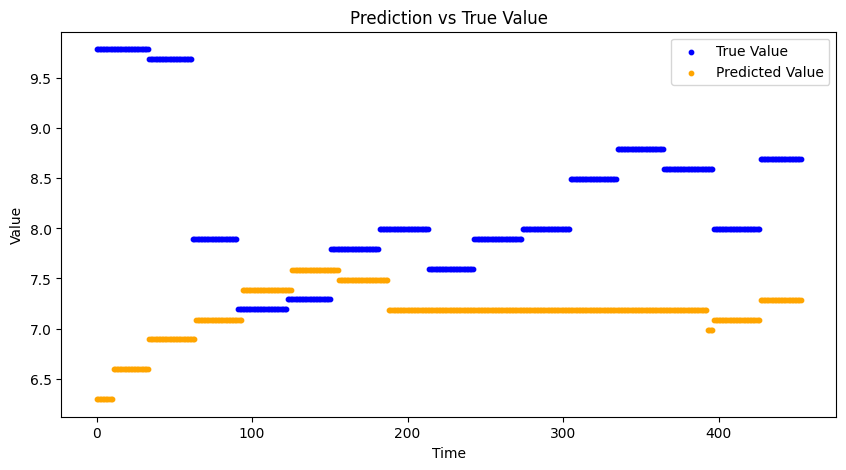

In [17]:
train_predictions_inverted = scaler.inverse_transform(train_predictions_2.reshape(-1, 1))
train_labels_inverted = scaler.inverse_transform(train_data_2[best_lag_2-1:].reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(train_labels_inverted, train_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(train_labels_inverted, train_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((train_labels_inverted - train_predictions_inverted) / train_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(train_labels_inverted, train_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(train_labels_inverted)), train_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(train_predictions_inverted)), train_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Mean Absolute Error: 1.275907800525292
Root Mean Squared Error: 1.3449886947706884
Mean Absolute Percentage Error: 0.15039376645547783
R-squared Error: -27.035609517685884


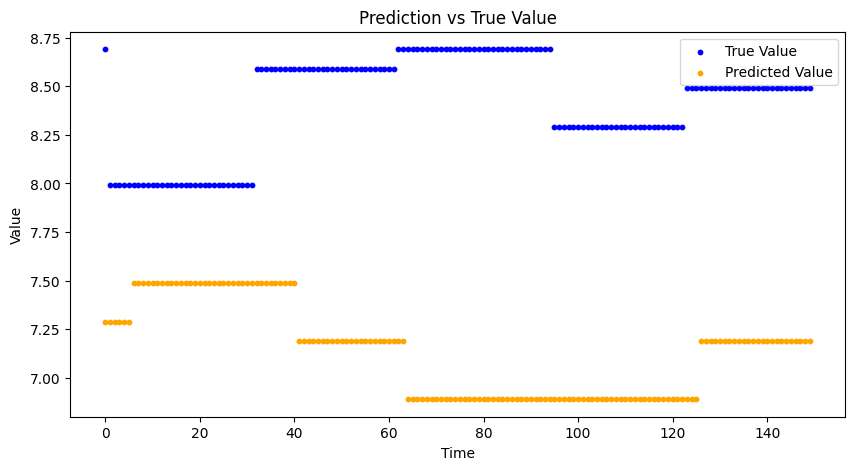

In [18]:
val_predictions_inverted = scaler.inverse_transform(val_predictions_2.reshape(-1, 1))
val_labels_inverted = scaler.inverse_transform(val_data_2.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(val_labels_inverted, val_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(val_labels_inverted, val_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((val_labels_inverted - val_predictions_inverted) / val_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(val_labels_inverted, val_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(val_labels_inverted)), val_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(val_predictions_inverted)), val_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Mean Absolute Error: 1.2206847413123494
Root Mean Squared Error: 1.2491993867989133
Mean Absolute Percentage Error: 0.14856852310687965
R-squared Error: -72.43674791881377


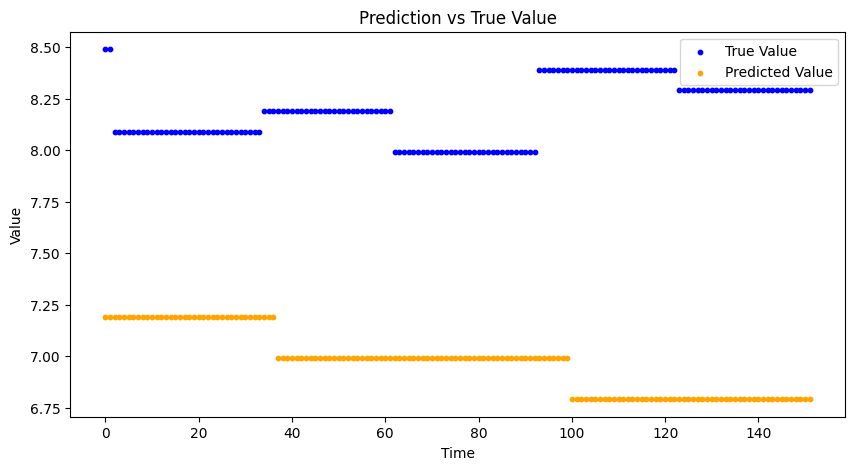

In [19]:
test_predictions_inverted = scaler.inverse_transform(test_predictions_2.reshape(-1, 1))
test_labels_inverted = scaler.inverse_transform(test_data_2.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(test_labels_inverted, test_predictions_inverted)
print(f"Mean Absolute Error: {mae}")

# Calculate RMSE
mse = mean_squared_error(test_labels_inverted, test_predictions_inverted)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((test_labels_inverted - test_predictions_inverted) / test_labels_inverted)) 
print(f"Mean Absolute Percentage Error: {mape}")

r2 = r2_score(test_labels_inverted, test_predictions_inverted)
print(f"R-squared Error: {r2}")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(test_labels_inverted)), test_labels_inverted, label='True Value', color='blue', s=10)  # Dots for true values
plt.scatter(range(len(test_predictions_inverted)), test_predictions_inverted, label='Predicted Value', color='orange', s=10)  # Dots for predictions
plt.title('Prediction vs True Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 5. Spatiotemporal Graph Convolutional Networks (STGCN)

## 6. structural equation model (SEM)

In [14]:
import semopy as sem
from semopy import Model
import pandas as pd
import numpy as np
from semopy import semplot
from graphviz import Digraph

In [2]:
data = pd.read_excel("Data_SEM.xlsx")
print(data.head())

      X1    X2       X3        X4    Y1    Y2
0  6.278  3452  223.988  0.128637  6.19  6.29
1  6.480  3452  223.988  0.128637  6.19  6.29
2  6.223  3452  223.988  0.128637  6.19  6.29
3  6.188  3452  223.988  0.128637  6.19  6.29
4  5.294  3452  224.857  0.127274  6.19  6.29


In [3]:
# Define the model
model_desc = """
Y1 ~ X1 + X2 + X3
Y2 ~ X1 + X2 + X3 + X4 + Y1
"""

In [4]:
model = Model(model_desc)
    
# Fit the model
results = model.fit(data)

print(results)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.096
Number of iterations: 56
Params: 0.811 -0.000 0.002 -0.007 0.000 0.003 -0.666 0.990 0.195 0.008


In [5]:
ins = model.inspect()
print(ins)

  lval  op rval  Estimate  Std. Err     z-value   p-value
0   Y1   ~   X1  0.810506  0.014696   55.151065  0.000000
1   Y1   ~   X2 -0.000285  0.000019  -15.090992  0.000000
2   Y1   ~   X3  0.002139  0.000747    2.862357  0.004205
3   Y2   ~   X1 -0.007028  0.004276   -1.643487  0.100282
4   Y2   ~   X2  0.000044  0.000004   10.730344  0.000000
5   Y2   ~   X3  0.003188  0.000229   13.907257  0.000000
6   Y2   ~   X4 -0.665601  0.031853  -20.896215  0.000000
7   Y2   ~   Y1  0.989875  0.003706  267.097552  0.000000
8   Y1  ~~   Y1  0.194998  0.004957   39.338277  0.000000
9   Y2  ~~   Y2  0.008289  0.000211   39.338276  0.000000


In [15]:
sem.calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,11,19,297.798751,0.0,25309.065044,0.98866,0.988234,0.979676,0.988234,0.980412,0.091798,19.807561,80.182993,0.096219


## 7. Sensitivity analysis

In [6]:
from SALib.analyze.sobol import analyze
from SALib.sample import saltelli
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from SALib.analyze import sobol

In [2]:
data = pd.read_excel("Data_SEM.xlsx")
print(data.head())

      X1    X2       X3        X4    Y1    Y2
0  6.278  3452  223.988  0.128637  6.19  6.29
1  6.480  3452  223.988  0.128637  6.19  6.29
2  6.223  3452  223.988  0.128637  6.19  6.29
3  6.188  3452  223.988  0.128637  6.19  6.29
4  5.294  3452  224.857  0.127274  6.19  6.29


In [3]:
# Define the problem
problem = {
    'num_vars': 4,
    'names': ['X1', 'X2', 'X3', 'X4'],
    'bounds': [
        [data['X1'].min(), data['X1'].max()],
        [data['X2'].min(), data['X2'].max()],
        [data['X3'].min(), data['X3'].max()],
        [data['X4'].min(), data['X4'].max()]
    ]
}

# Generate samples
num_samples = 1000
param_values = saltelli.sample(problem, num_samples)

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(data[['X1', 'X2', 'X3', 'X4']], data['Y1'])

# Evaluate the model with the sampled data
Y = model.predict(param_values)

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(data[['X1', 'X2', 'X3', 'X4']], data['Y1'])

C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_1644\3893730584.py:15: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, num_samples)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


LinearRegression()

In [4]:
# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# First-Order Sensitivity Indices
print(Si['S1'])

# Total Efffect Sensitivity Indices
print(Si['ST'])

# Total Efffect Sensitivity Indices
print(Si['ST'])

[0.91483157 0.01184879 0.03377073 0.03633437]
[0.91373925 0.01247004 0.03327554 0.03622612]
[0.91373925 0.01247004 0.03327554 0.03622612]


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


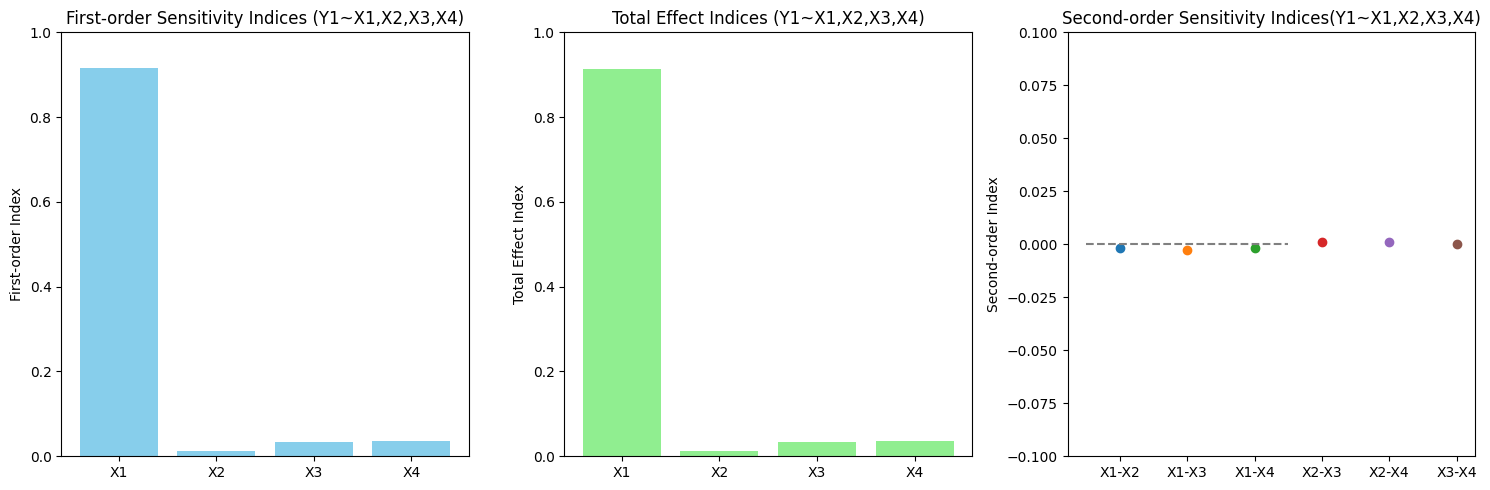

In [8]:
# 'Si' is the sensitivity analysis result object
first_order = Si['S1']
total_effect = Si['ST']
second_order = Si['S2']

# Names of parameters
params = problem['names']  # This should match the 'names' field in your problem definition

# First-order and total-effect indices plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting first-order sensitivity indices
axes[0].bar(params, first_order, color='skyblue')
axes[0].set_title('First-order Sensitivity Indices (Y1~X1,X2,X3,X4)')
axes[0].set_ylabel('First-order Index')
axes[0].set_ylim([0, 1])

# Plotting total effect sensitivity indices
axes[1].bar(params, total_effect, color='lightgreen')
axes[1].set_title('Total Effect Indices (Y1~X1,X2,X3,X4)')
axes[1].set_ylabel('Total Effect Index')
axes[1].set_ylim([0, 1])

# Plotting second-order sensitivity indices
# Adjust the second-order index plotting according to the actual data structure
for i in range(len(params)):
    for j in range(i+1, len(params)):
        axes[2].scatter([f"{params[i]}-{params[j]}"], [second_order[i, j]], label=f"{params[i]}-{params[j]}")
axes[2].set_title('Second-order Sensitivity Indices(Y1~X1,X2,X3,X4)')
axes[2].set_ylabel('Second-order Index')
axes[2].hlines(0, -0.5, len(params)-1.5, colors='gray', linestyles='dashed')  # Zero line for reference
axes[2].set_ylim([-0.1, 0.1])

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

In [9]:
# Define the problem
problem = {
    'num_vars': 4,
    'names': ['X1', 'X2', 'X3', 'X4'],
    'bounds': [
        [data['X1'].min(), data['X1'].max()],
        [data['X2'].min(), data['X2'].max()],
        [data['X3'].min(), data['X3'].max()],
        [data['X4'].min(), data['X4'].max()]
    ]
}

# Generate samples
num_samples = 1000
param_values = saltelli.sample(problem, num_samples)

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(data[['X1', 'X2', 'X3', 'X4']], data['Y2'])

# Evaluate the model with the sampled data
Y = model.predict(param_values)

C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_1644\384109919.py:15: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, num_samples)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [20]:
print(data['X1'].min())
print(data['X1'].max())
print(data['X2'].min())
print(data['X2'].max())

2.786
8.924
1220
3452


In [10]:
# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# First-Order Sensitivity Indices
print(Si['S1'])

# Total Efffect Sensitivity Indices
print(Si['ST'])

# Second-Order Sensitivity Indices
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

[0.8825124  0.00791264 0.05007301 0.05664665]
[0.88120804 0.00837388 0.04946683 0.05644394]
x1-x2: -0.0020510496114971542
x1-x3: -0.0031917046754258785
x2-x3: 0.0008121881941996409


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


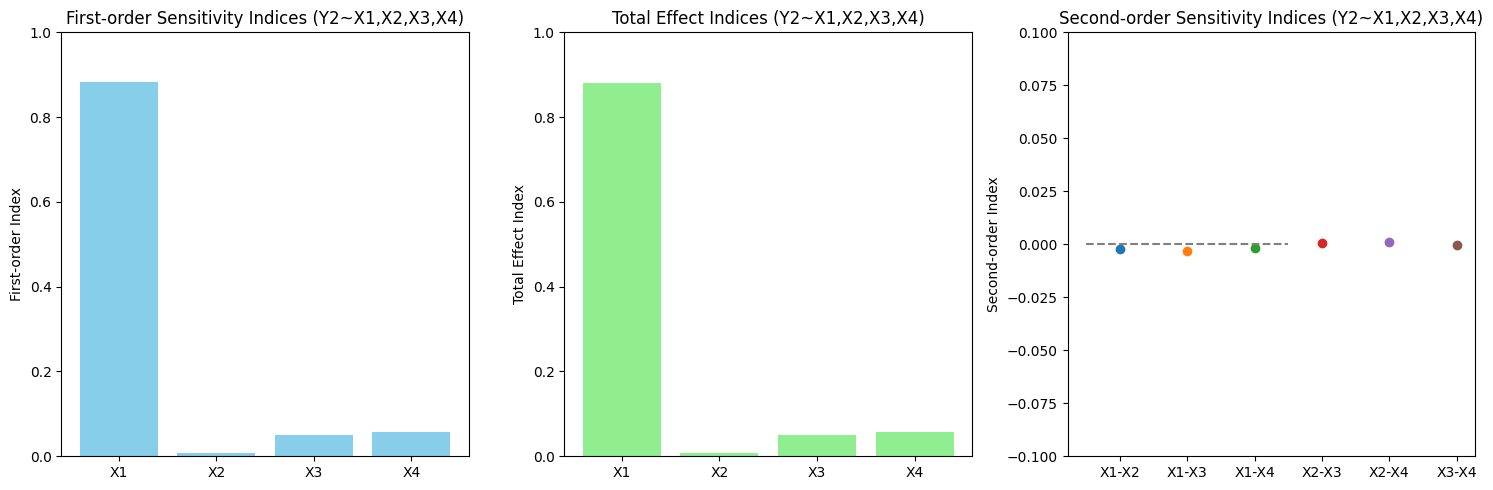

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 'Si' is the sensitivity analysis result object
first_order = Si['S1']
total_effect = Si['ST']
second_order = Si['S2']

# Names of parameters
params = problem['names']  # This should match the 'names' field in your problem definition

# First-order and total-effect indices plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting first-order sensitivity indices
axes[0].bar(params, first_order, color='skyblue')
axes[0].set_title('First-order Sensitivity Indices (Y2~X1,X2,X3,X4)')
axes[0].set_ylabel('First-order Index')
axes[0].set_ylim([0, 1])

# Plotting total effect sensitivity indices
axes[1].bar(params, total_effect, color='lightgreen')
axes[1].set_title('Total Effect Indices (Y2~X1,X2,X3,X4)')
axes[1].set_ylabel('Total Effect Index')
axes[1].set_ylim([0, 1])

# Plotting second-order sensitivity indices
# Adjust the second-order index plotting according to the actual data structure
for i in range(len(params)):
    for j in range(i+1, len(params)):
        axes[2].scatter([f"{params[i]}-{params[j]}"], [second_order[i, j]], label=f"{params[i]}-{params[j]}")
axes[2].set_title('Second-order Sensitivity Indices (Y2~X1,X2,X3,X4)')
axes[2].set_ylabel('Second-order Index')
axes[2].hlines(0, -0.5, len(params)-1.5, colors='gray', linestyles='dashed')  # Zero line for reference
axes[2].set_ylim([-0.1, 0.1])

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


In [12]:
# Define the problem
problem = {
    'num_vars': 5,
    'names': ['X1', 'X2', 'X3', 'X4', 'Y1'],
    'bounds': [
        [data['X1'].min(), data['X1'].max()],
        [data['X2'].min(), data['X2'].max()],
        [data['X3'].min(), data['X3'].max()],
        [data['X4'].min(), data['X4'].max()],
        [data['Y1'].min(), data['Y1'].max()]

    ]
}

# Generate samples
num_samples = 1000
param_values = saltelli.sample(problem, num_samples)

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(data[['X1', 'X2', 'X3', 'X4', 'Y1']], data['Y2'])

# Evaluate the model with the sampled data
Y = model.predict(param_values)

C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_1644\3060722481.py:17: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, num_samples)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [14]:
# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Print first-order indices
print("First-order indices:")
for i, name in enumerate(problem['names']):
    print(f"{name}: {Si['S1'][i]}")

# Print total-effect indices
print("\nTotal-effect indices:")
for i, name in enumerate(problem['names']):
    print(f"{name}: {Si['ST'][i]}")

# Print second-order indices
print("\nSecond-order indices:")
for i in range(len(problem['names'])):
    for j in range(i + 1, len(problem['names'])):
        print(f"{problem['names'][i]}-{problem['names'][j]}: {Si['S2'][i, j]}")

First-order indices:
X1: 0.00017569957168482348
X2: 0.0004923486249143826
X3: 0.002401062753914536
X4: 0.002538196013460012
Y1: 0.9947179558625131

Total-effect indices:
X1: 0.00017910634358264826
X2: 0.00047308577727975064
X3: 0.002089373902233804
X4: 0.0029030591588423372
Y1: 0.9946815818948204

Second-order indices:
X1-X2: 1.8070299957048154e-05
X1-X3: 1.4078935641633882e-05
X1-X4: 1.6381129408583016e-05
X1-Y1: 9.02075623510079e-06
X2-X3: -0.0001153019091469378
X2-X4: -0.00011780093615152256
X2-Y1: -3.379473825093626e-05
X3-X4: -0.00020895992673786992
X3-Y1: -0.000633266150355638
X4-Y1: 0.0007200346770080968


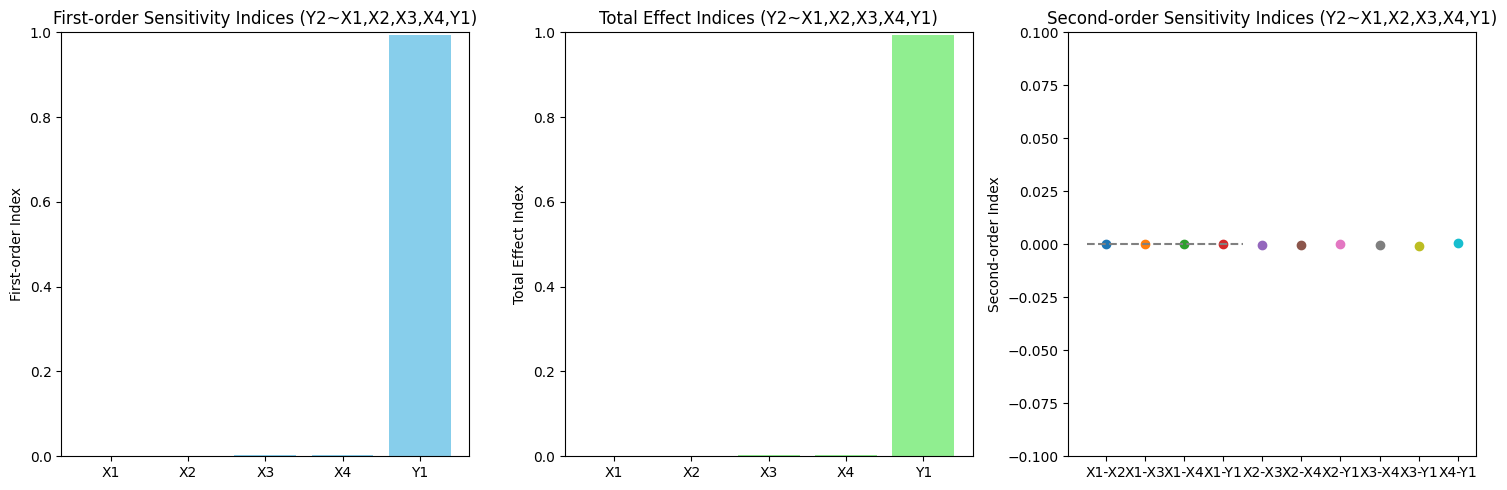

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 'Si' is the sensitivity analysis result object
first_order = Si['S1']
total_effect = Si['ST']
second_order = Si['S2']

# Names of parameters
params = problem['names']  # This should match the 'names' field in your problem definition

# First-order and total-effect indices plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting first-order sensitivity indices
axes[0].bar(params, first_order, color='skyblue')
axes[0].set_title('First-order Sensitivity Indices (Y2~X1,X2,X3,X4,Y1)')
axes[0].set_ylabel('First-order Index')
axes[0].set_ylim([0, 1])

# Plotting total effect sensitivity indices
axes[1].bar(params, total_effect, color='lightgreen')
axes[1].set_title('Total Effect Indices (Y2~X1,X2,X3,X4,Y1)')
axes[1].set_ylabel('Total Effect Index')
axes[1].set_ylim([0, 1])

# Plotting second-order sensitivity indices
# Adjust the second-order index plotting according to the actual data structure
for i in range(len(params)):
    for j in range(i+1, len(params)):
        axes[2].scatter([f"{params[i]}-{params[j]}"], [second_order[i, j]], label=f"{params[i]}-{params[j]}")
axes[2].set_title('Second-order Sensitivity Indices (Y2~X1,X2,X3,X4,Y1)')
axes[2].set_ylabel('Second-order Index')
axes[2].hlines(0, -0.5, len(params)-1.5, colors='gray', linestyles='dashed')  # Zero line for reference
axes[2].set_ylim([-0.1, 0.1])

# Improve layout
plt.tight_layout()

# Show plot
plt.show()